# Tutorial about analysis routines

# Coordinate-based Colocalization

Coordinate-based colocalization of two selections is computed as introduced by Malkusch et al. (1). A local density of locdata A is compared with the local density of locdata B within a varying radius for each localization in selection A. Local densities at various radii are compared by Spearman-rank-correlation and weighted by an exponential factor including the Euclidean distance to the nearest neighbor for each localization. The colocalization coefficient can take a value between -1 and 1 with -1 indicating anti-correlation (i.e. nearby localizations of selection B), 0 no colocalization, 1 strong colocalization.

The colocalization coefficient is provided as property for each localization within the corresponding dataset. The property key refers to colocalizing locdata A with locdata B.

## Initial setup

In [1]:
from pathlib import Path

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import surepy as sp

In [2]:
sp.show_versions(system=False, dependencies=False, verbose=False)


Surepy:
   version: 0.7.dev3+gb9aca40

Python:
   version: 3.8.8


## Synthetic data

Provide synthetic data made of clustered localizations that are normal distributed around their center positions.

In [3]:
def set_centers(n_centers_1d=3, feature_range = (0, 1000)):
    dist = (feature_range[1] - feature_range[0])/(n_centers_1d + 1)
    centers = np.mgrid[feature_range[0] + dist : feature_range[1] : dist, feature_range[0] + dist : feature_range[1] : dist].reshape(2, -1).T
    return centers

In [4]:
n_centers_1d = 3 
feature_range = (0, 1000)
centers = set_centers(n_centers_1d, feature_range)

In [5]:
dat = sp.simulate_Thomas(centers=centers, n_samples=len(centers)*100, n_features=2, feature_range=feature_range, cluster_std=20, seed=1)

dat.print_summary()

identifier: "1"
comment: ""
creation_date: "2021-03-04 13:43:32 +0100"
modification_date: ""
source: SIMULATION
state: RAW
element_count: 900
frame_count: 0
file_type: UNKNOWN_FILE_TYPE
file_path: ""



A second dataset is provided by shifting the first dataset by an offset.

In [6]:
dat_trans = sp.transform_affine(dat, offset=(20,0))
dat_trans.print_summary()

identifier: "2"
comment: ""
creation_date: "2021-03-04 13:43:32 +0100"
modification_date: "2021-03-04 13:43:32 +0100"
source: SIMULATION
state: MODIFIED
element_count: 900
frame_count: 0
file_type: UNKNOWN_FILE_TYPE
file_path: ""



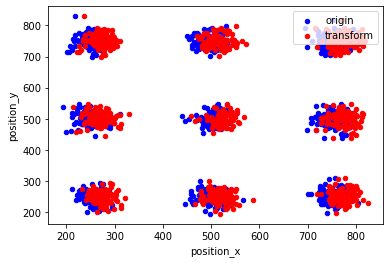

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='origin')
dat_trans.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Red', label='transform')
plt.show()

## CBC computation

In [8]:
cbc = sp.CoordinateBasedColocalization(radius=100, n_steps=10).compute(locdata=dat, other_locdata=dat_trans)

In [9]:
cbc.results.head()

,colocalization_cbc_2
0,0.449895
1,0.512648
2,0.180717
3,-0.032354
4,0.482281


## Results

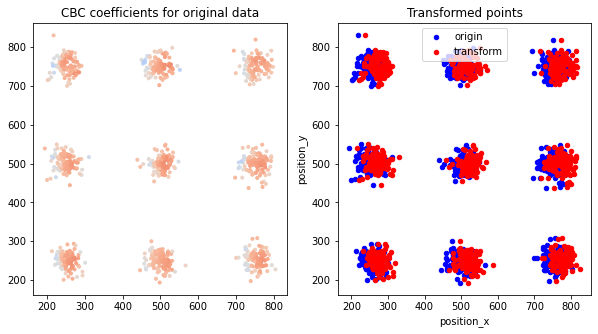

In [10]:
points = dat.coordinates
color = cbc.results['colocalization_cbc_2'].values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(x=points[:,0], y=points[:,1], marker='.', c=color, cmap='coolwarm', norm= colors.Normalize(-1., 1.), label='points')
axes[0].set_title('CBC coefficients for original data')

# axes[1].scatter(x=points[:,0], y=points[:,1], marker='.', color='Blue', label='points')
# axes[1].scatter(x=points_trans[:,0], y=points_trans[:,1], marker='o', color='Red', label='transformed points')
dat.data.plot.scatter(x='position_x', y='position_y', ax=axes[1], color='Blue', label='origin')
dat_trans.data.plot.scatter(x='position_x', y='position_y', ax=axes[1], color='Red', label='transform')
axes[1].set_title('Transformed points')

plt.show()

## CBC for various shifts

In [11]:
n_centers_1d = 3 
feature_range = (0, 2000)
centers = set_centers(n_centers_1d, feature_range)

In [12]:
dat = sp.simulate_Thomas(centers=centers, n_samples=len(centers)*100, n_features=2, feature_range=feature_range, cluster_std=20, seed=1)

dat.print_summary()

identifier: "3"
comment: ""
creation_date: "2021-03-04 13:43:33 +0100"
modification_date: ""
source: SIMULATION
state: RAW
element_count: 900
frame_count: 0
file_type: UNKNOWN_FILE_TYPE
file_path: ""



In [13]:
offsets = [0, 50, 100, 200]
dat_trans_list = [sp.transform_affine(dat, offset=(offset, 0)) for offset in offsets]

In [14]:
cbc_list = [sp.CoordinateBasedColocalization(radius=100, n_steps=10).compute(locdata=dat, other_locdata=other_dat) for other_dat in dat_trans_list]

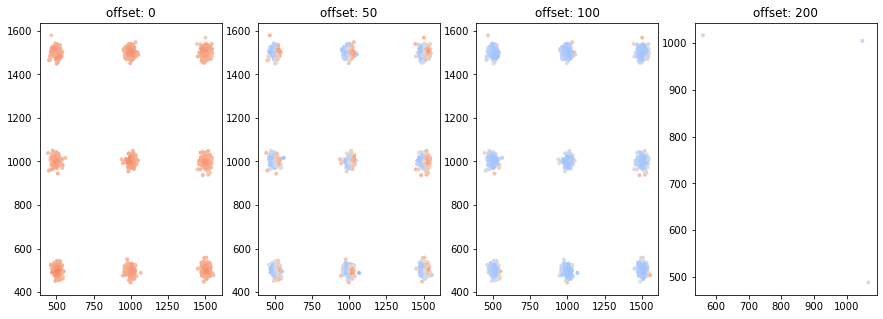

In [15]:
points = dat.coordinates
n_rows = 1
n_cols = 4

fig = plt.figure(figsize=(15, 5))
for n, (cbc, offset) in enumerate(zip(cbc_list, offsets)):
    ax = fig.add_subplot(n_rows, n_cols, n+1)
    color = cbc.results.iloc[:, 0].values
    ax.scatter(x=points[:,0], y=points[:,1], marker='.', c=color, cmap='coolwarm', norm=colors.Normalize(-1., 1.))
    ax.set_title(f'offset: {offset}')
plt.show()

## CBC on various length scales (for small cluster)

In [16]:
n_centers_1d = 3 
feature_range = (0, 2000)
centers = set_centers(n_centers_1d, feature_range)

In [17]:
dat = sp.simulate_Thomas(centers=centers, n_samples=len(centers)*100, n_features=2, feature_range=feature_range, cluster_std=20, seed=1)

In [18]:
offsets = [0, 50, 100, 200]
dat_trans_list = [sp.transform_affine(dat, offset=(offset,0)) for offset in offsets]

In [19]:
radii = [50, 100, 150, 200, 250, 300, 350, 400]
cbc_list = [sp.CoordinateBasedColocalization(radius=radius, n_steps=10).compute(locdata=dat, other_locdata=other_dat) for radius in radii 
            for other_dat in dat_trans_list
           ]

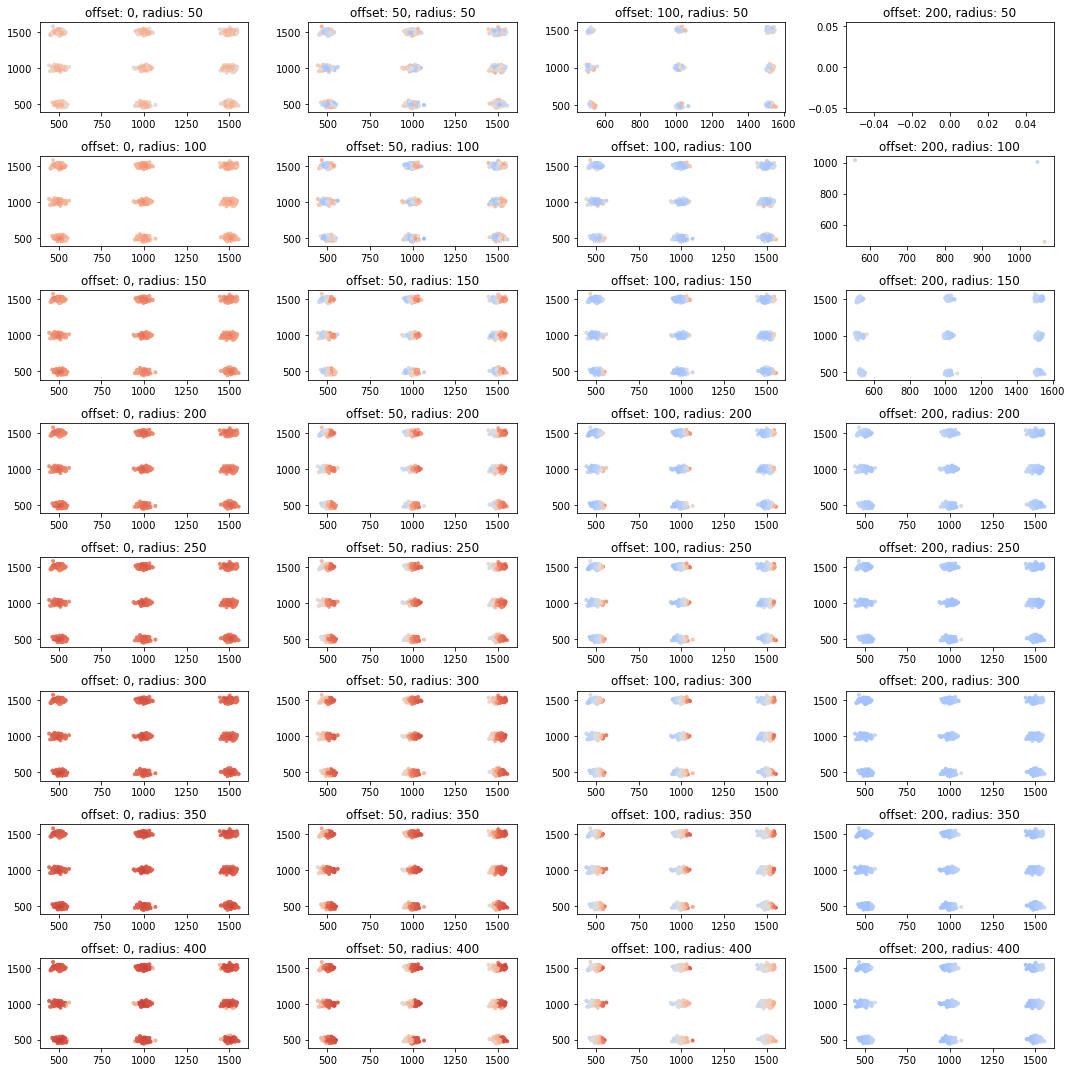

In [20]:
points = dat.coordinates
params = [(radius, offset) for radius in radii for offset in offsets]

n_rows = len(radii)
n_cols = len(offsets)

fig = plt.figure(figsize=(15, 15))
for n, (cbc, (radius, offset)) in enumerate(zip(cbc_list, params)):
    ax = fig.add_subplot(n_rows, n_cols, n+1)
    color = cbc.results.iloc[:, 0].values
    ax.scatter(x=points[:,0], y=points[:,1], marker='.', c=color, cmap='coolwarm', norm=colors.Normalize(-1., 1.))
    ax.set_title(f'offset: {offset}, radius: {radius}')
plt.tight_layout()
plt.show()

## CBC on various length scales (for larger cluster)

In [21]:
n_centers_1d = 3 
feature_range = (0, 10_000)
centers = set_centers(n_centers_1d, feature_range)

In [22]:
dat = sp.simulate_Thomas(centers=centers, n_samples=len(centers)*100, n_features=2, feature_range=feature_range, cluster_std=100, seed=1)

In [23]:
offsets = [0, 50, 100, 200]
dat_trans_list = [sp.transform_affine(dat, offset=(offset,0)) for offset in offsets]

In [24]:
radii = [50, 100, 150, 200, 250, 300, 350, 400]
cbc_list = [sp.CoordinateBasedColocalization(radius=radius, n_steps=10).compute(locdata=dat, other_locdata=other_dat) for radius in radii 
            for other_dat in dat_trans_list
           ]

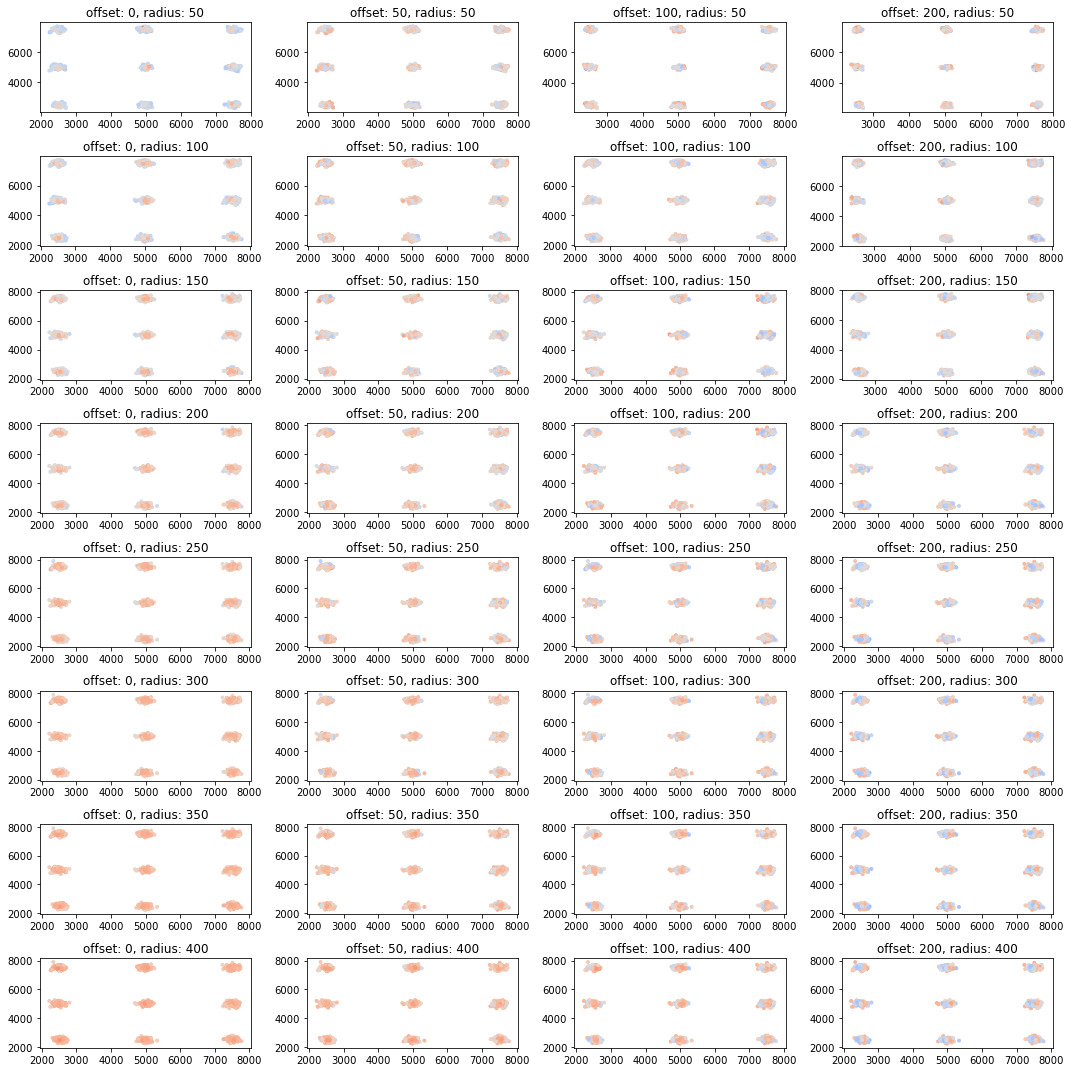

In [25]:
points = dat.coordinates
params = [(radius, offset) for radius in radii for offset in offsets]

n_rows = len(radii)
n_cols = len(offsets)

fig = plt.figure(figsize=(15, 15))
for n, (cbc, (radius, offset)) in enumerate(zip(cbc_list, params)):
    ax = fig.add_subplot(n_rows, n_cols, n+1)
    color = cbc.results.iloc[:, 0].values
    ax.scatter(x=points[:,0], y=points[:,1], marker='.', c=color, cmap='coolwarm', norm=colors.Normalize(-1., 1.))
    ax.set_title(f'offset: {offset}, radius: {radius}')
plt.tight_layout()
plt.show()